# ARIMA Forecasting of HDFCBANK and ICICI bank stock price 

### SECTION 1: Import libraries and HDFC 1day data

In [1]:
# For data procesing
import pandas as pd

# For data transformation
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-darkgrid')

# For Historical data
import yfinance as yf

# To check for date index
from datetime import datetime,timedelta,date

## To check stationarity
from statsmodels.tsa.stattools import adfuller

## For time series modelling
from statsmodels.tsa.arima.model import ARIMA

## To check for auto correlation
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

## For volatility forecasting
from arch import arch_model

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
##### HDFC BANK 1 day data 
end = datetime.today()
start2 = date(2021,3,1)
HDFCBANK1d = yf.download("HDFCBANK.NS",start = start2,end= end,interval = '1d',auto_adjust = False)
HDFCBANK1d = HDFCBANK1d.droplevel(level = 1,axis = 1)

[*********************100%***********************]  1 of 1 completed


In [66]:
##### ICICIBANK1d 1 data data 
end = datetime.today()
start2 = date(2021,3,1)
ICICIBANK1d = yf.download("ICICIBANK.NS",start = start2,end= end,interval = '1d',auto_adjust = False)
ICICIBANK1d = ICICIBANK1d.droplevel(level = 1,axis = 1)

[*********************100%***********************]  1 of 1 completed


## Plotting the ICICIBANK and HDFCBANK data

<Axes: xlabel='Date'>

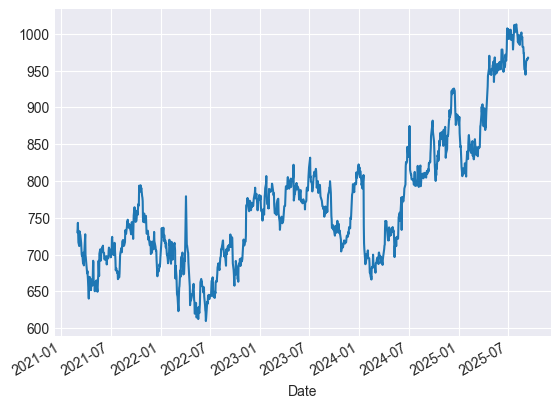

In [4]:
HDFCBANK1d['Adj Close'].plot()

<Axes: xlabel='Date'>

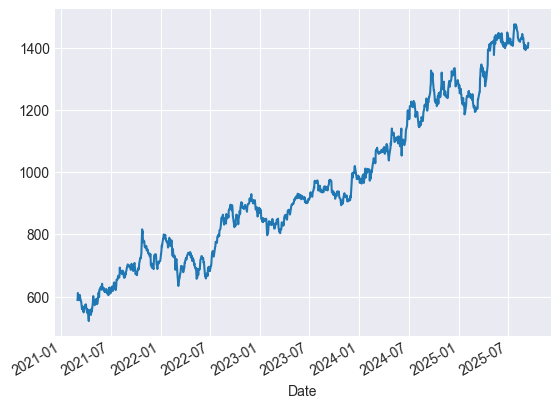

In [67]:
ICICIBANK1d['Adj Close'].plot()

## Dropping all the column except the Adj Close 

In [68]:
ICICIBANK1d1d = ICICIBANK1d.drop(columns = ['Volume','Open','High','Low','Close'])

In [ ]:
HDFCBANK1d = HDFCBANK1d.drop(columns = ['Volume','Open','High','Low','Close'])

## Step 2 : Check for Stationary, using Augmented Dickey Fuller test

#### Finding percent change in reliance and HDFCBANK data 

In [8]:
HDFCBANK1d['daily_returns'] = (HDFCBANK1d['Adj Close'].pct_change()).dropna()

In [70]:
ICICIBANK1d['daily_returns'] = ICICIBANK1d['Adj Close'].pct_change()

In [71]:
# Check if our returns are stationary (required for AR models)
def check_stationarity_quick(the_series, name):
    """
    Quick stationarity check - the foundation of all time series models
    """
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(the_series.dropna())
    
    print(f"Stationarity test performed on {name}:")
    print("=" * 50)
    print(f"ADF statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.5f}")
    print(f"Critical values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print("✅ STATIONARY: Good for modeling!")
    else:
        print("❌ NON-STATIONARY: Need to transform the data.")
    print()

# Test stationarity
check_stationarity_quick(HDFCBANK1d['Adj Close'], f"HDFCBANK stock prices")
check_stationarity_quick(HDFCBANK1d['daily_returns'], f"HDFCBANK stock returns")
check_stationarity_quick(ICICIBANK1d['Adj Close'], f"Reliance stock prices")
check_stationarity_quick(ICICIBANK1d['daily_returns'], f"Reliance stock returns")

print("Key insights")
print("=" * 50)
print("Prices are non-stationary (they trend).")
print("Returns are stationary (they fluctuate around a stable mean).")


Stationarity test performed on HDFCBANK stock prices:
ADF statistic: -1.2483
p-value: 0.65249
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
❌ NON-STATIONARY: Need to transform the data.

Stationarity test performed on HDFCBANK stock returns:
ADF statistic: -13.0258
p-value: 0.00000
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
✅ STATIONARY: Good for modeling!

Stationarity test performed on Reliance stock prices:
ADF statistic: -0.4506
p-value: 0.90129
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
❌ NON-STATIONARY: Need to transform the data.

Stationarity test performed on Reliance stock returns:
ADF statistic: -16.8240
p-value: 0.00000
Critical values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
✅ STATIONARY: Good for modeling!

Key insights
Prices are non-stationary (they trend).
Returns are stationary (they fluctuate around a stable mean).


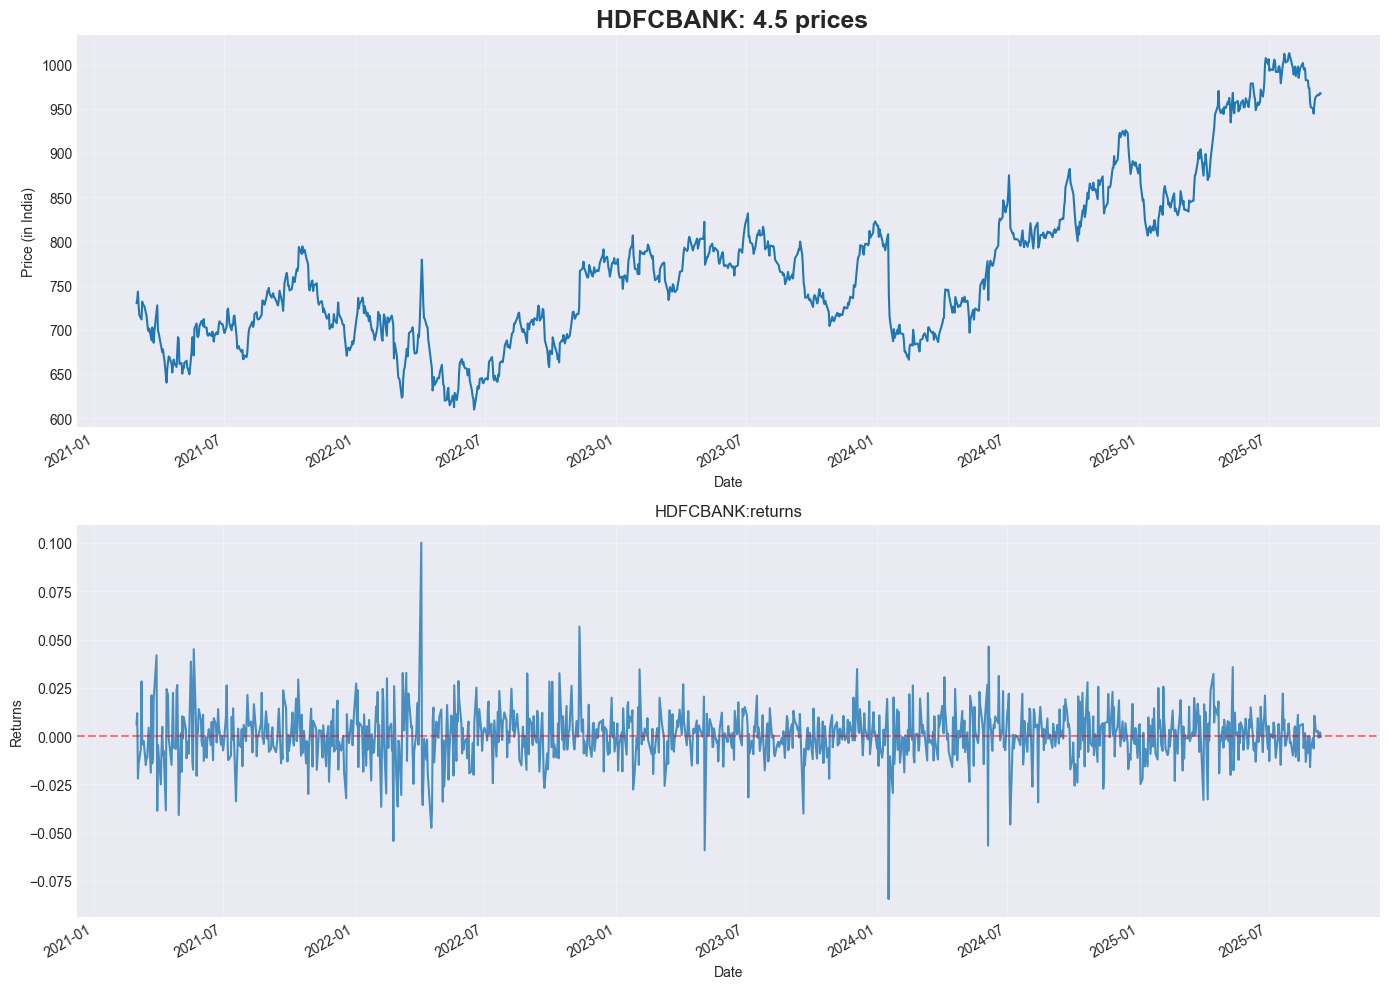


Mean return: 0.0003 (8.56% annualized)
 volatility: 0.0133 (21.16% annualized)


In [11]:
## Visualizing the data
## Calculate the number of years 
years_span = (HDFCBANK1d.index[-1]- HDFCBANK1d.index[0]).days/365.25
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (14,10))

HDFCBANK1d['Adj Close'].plot(ax = ax1,linewidth = 1.5)
ax1.set_title(f' HDFCBANK: {years_span:.1f} prices', fontsize=18, fontweight='bold')
ax1.set_ylabel('Price (in India)')
ax1.grid(True, alpha=0.3)


HDFCBANK1d['daily_returns'].plot(ax=ax2, title=f'HDFCBANK:returns', alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Returns')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMean return: {HDFCBANK1d['daily_returns'].mean():.4f} ({HDFCBANK1d['daily_returns'].mean() * 252:.2%} annualized)")
print(f" volatility: {HDFCBANK1d['daily_returns'].std():.4f} ({HDFCBANK1d['daily_returns'].std() * np.sqrt(252):.2%} annualized)")



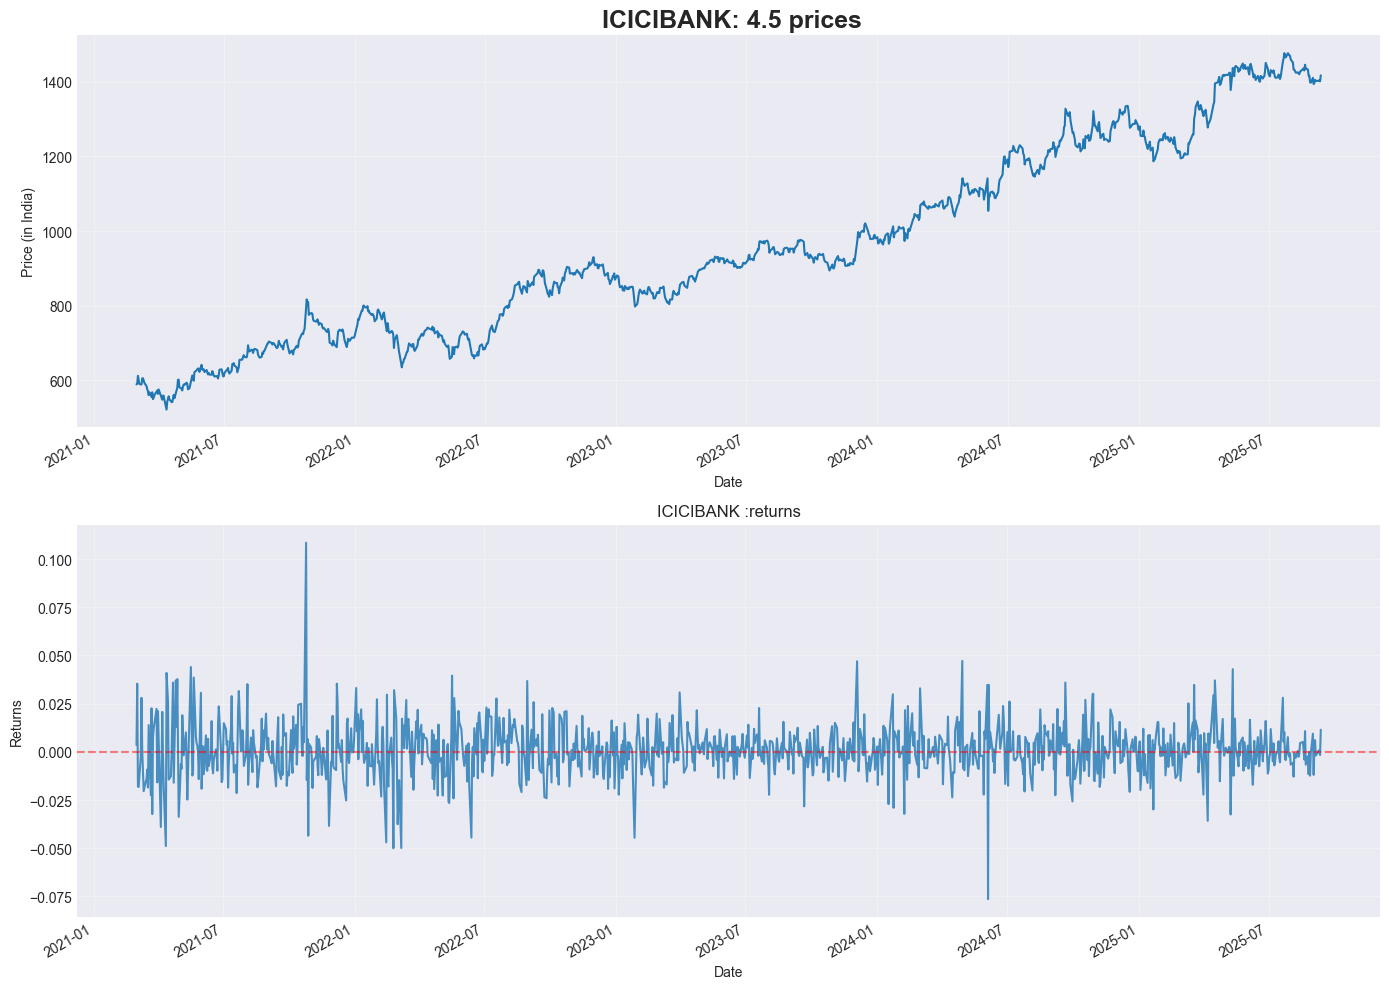


Mean return: 0.0009 (22.01% annualized)
 volatility: 0.0134 (21.27% annualized)


In [72]:
## Visualizing the data
## Calculate the number of years 
years_span = (ICICIBANK1d.index[-1]- ICICIBANK1d.index[0]).days/365.25
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (14,10))

ICICIBANK1d['Adj Close'].plot(ax = ax1,linewidth = 1.5)
ax1.set_title(f' ICICIBANK: {years_span:.1f} prices', fontsize=18, fontweight='bold')
ax1.set_ylabel('Price (in India)')
ax1.grid(True, alpha=0.3)


ICICIBANK1d['daily_returns'].plot(ax=ax2, title=f'ICICIBANK :returns', alpha=0.8)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Returns')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMean return: {ICICIBANK1d['daily_returns'].mean():.4f} ({ICICIBANK1d['daily_returns'].mean() * 252:.2%} annualized)")
print(f" volatility: {ICICIBANK1d['daily_returns'].std():.4f} ({ICICIBANK1d['daily_returns'].std() * np.sqrt(252):.2%} annualized)")

## Step 3: Plotting the ACF and PACF charts to see for order of Auto regression and Moving Average in Reliance and HDFCBANK

In [13]:
import statsmodels.api as sm

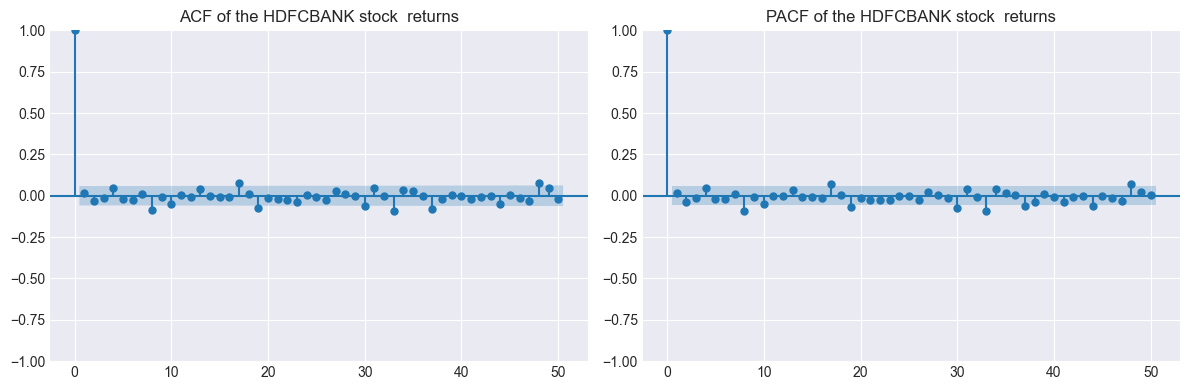

In [14]:
# Look for patterns in returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(HDFCBANK1d['daily_returns'].dropna(), lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(HDFCBANK1d['daily_returns'].dropna(), lags=50, ax=ax2)
ax1.set_title(f"ACF of the HDFCBANK stock  returns")
ax2.set_title(f"PACF of the HDFCBANK stock  returns")
plt.tight_layout()
plt.show()

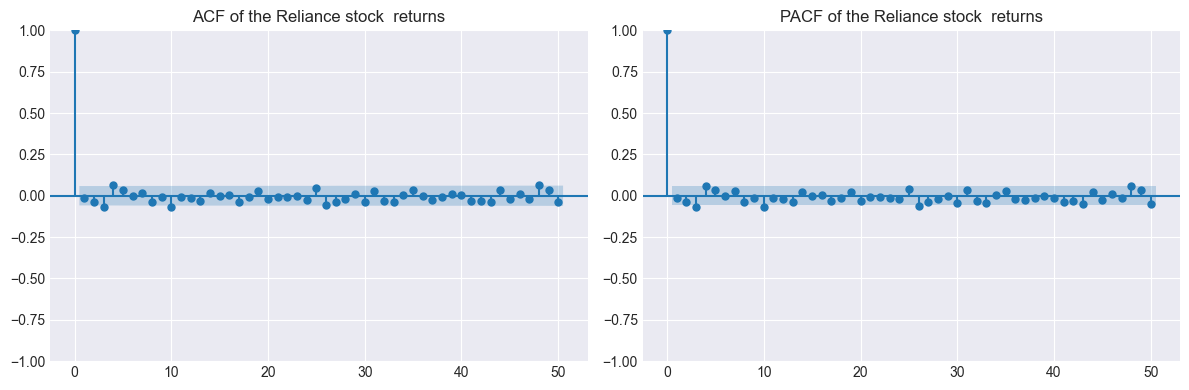

In [73]:
# Look for patterns in returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(ICICIBANK1d['daily_returns'].dropna(), lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(ICICIBANK1d['daily_returns'].dropna(), lags=50, ax=ax2)
ax1.set_title(f"ACF of the Reliance stock  returns")
ax2.set_title(f"PACF of the Reliance stock  returns")
plt.tight_layout()
plt.show()

## Step 4: Splitting the data into training and testing dataset for ARIMA forecasting

In [74]:
## Splitting the data into 70% training and 30% testing
split = int(len(ICICIBANK1d)*0.7)
ICICIBANK_train_1d = ICICIBANK1d[:split]
ICICIBANK_test_1d = ICICIBANK1d[split:]

ICICIBANK_train_1d.shape[0],ICICIBANK_test_1d.shape[0]

(786, 337)

In [17]:
## Splitting the data into 70% training and 30% testing
split = int(len(HDFCBANK1d)*0.7)
HDFC_train_1d = HDFCBANK1d[:split]
HDFC_test_1d = HDFCBANK1d[split:]

HDFC_train_1d.shape[0],HDFC_test_1d.shape[0]

(786, 337)

## Step 5 Finding the best order for Seasonal ARIMA Model 

In [18]:

import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

In [19]:
from pmdarima import auto_arima

#### ARIMA(0,1,0) = random walk:  If the series Y is not stationary, the simplest possible model for it is a random walk model, which can be considered as a limiting case of an AR(1) model in which the autoregressive coefficient is equal to 1, i.e., a series with infinitely slow mean reversion.  The prediction equation for this model can be written as:

Ŷt  - Yt-1   =  μ

or equivalently

Ŷt  =   μ + Yt-1

...where the constant term is the average period-to-period change (i.e. the long-term drift) in Y.  This model could be fitted as a no-intercept regression model in which the first difference of Y is the dependent variable.  Since it includes (only) a nonseasonal difference and a constant term, it is classified as an "ARIMA(0,1,0) model with constant." The random-walk-without-drift model would be an ARIMA(0,1,0) model without constant

## Step 6 Fitting the model and performing rolling walk forword prediction

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:

# Function for predicting prices using SARIMA
def get_predicted_prices(close_prices, order_params, seasonal_params):
    """
    close_prices   : pandas.Series of prices
    order_params   : tuple (p,d,q)
    seasonal_params: tuple (P,D,Q,m)
    """
    # Define the SARIMA model (same structure as your ARIMA code)
    best_model = SARIMAX(
        close_prices.values,
        order=order_params,
        seasonal_order=seasonal_params,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})

    # Make one-step forecast
    prediction = best_model_fit.forecast(steps=1)[0]
    return prediction

In [32]:
# Calculate minimum observations needed for SARIMA (non-seasonal order only)
min_obs = (
    max(best_params['order'][0], best_params['order'][2]) + best_params['order'][1]
)

# Prepare test DataFrame
HDFC_test_1d = HDFC_test_1d.copy()
HDFC_test_1d['predicted_price'] = np.nan

# Column index to speed up assignment
col_idx = HDFC_test_1d.columns.get_loc('predicted_price')

# Rolling forecast loop
for i in tqdm(range(min_obs, len(HDFC_test_1d))):
    # Combine training data + test data up to current point
    history = pd.concat([
        HDFC_train_1d['Adj Close'],
        HDFC_test_1d['Adj Close'].iloc[:i]
    ])

    print("step", i, "history length", len(history))  # debug info

    # --- main change: pass both non-seasonal and seasonal orders ---
    pred = get_predicted_prices(
        history,
        best_params['order'],
        best_params['seasonal_order']
    )

    # Store the one-step forecast
    HDFC_test_1d.iloc[i, col_idx] = pred


  0%|▏                                                                                 | 1/336 [00:00<01:03,  5.26it/s]

step 1 history length 787


  1%|▉                                                                                 | 4/336 [00:00<00:21, 15.54it/s]

step 2 history length 788
step 3 history length 789
step 4 history length 790
step 5 history length 791
step 6 history length 792
step 7 history length 793
step 8 history length 794


  4%|██▉                                                                              | 12/336 [00:00<00:11, 27.55it/s]

step 9 history length 795
step 10 history length 796
step 11 history length 797
step 12 history length 798
step 13 history length 799
step 14 history length 800
step 15 history length 801
step 16 history length 802


  6%|████▊                                                                            | 20/336 [00:00<00:10, 31.13it/s]

step 17 history length 803
step 18 history length 804
step 19 history length 805
step 20 history length 806
step 21 history length 807
step 22 history length 808
step 23 history length 809


  8%|██████▊                                                                          | 28/336 [00:01<00:09, 31.71it/s]

step 24 history length 810
step 25 history length 811
step 26 history length 812
step 27 history length 813
step 28 history length 814
step 29 history length 815
step 30 history length 816


 11%|████████▋                                                                        | 36/336 [00:01<00:09, 33.21it/s]

step 31 history length 817
step 32 history length 818
step 33 history length 819
step 34 history length 820
step 35 history length 821
step 36 history length 822
step 37 history length 823


 12%|█████████▋                                                                       | 40/336 [00:01<00:08, 33.20it/s]

step 38 history length 824
step 39 history length 825
step 40 history length 826
step 41 history length 827
step 42 history length 828
step 43 history length 829
step 44 history length 830


 15%|████████████▌                                                                    | 52/336 [00:01<00:08, 34.38it/s]

step 45 history length 831
step 46 history length 832
step 47 history length 833
step 48 history length 834
step 49 history length 835
step 50 history length 836
step 51 history length 837
step 52 history length 838


 17%|█████████████▌                                                                   | 56/336 [00:01<00:08, 34.76it/s]

step 53 history length 839
step 54 history length 840
step 55 history length 841
step 56 history length 842
step 57 history length 843
step 58 history length 844
step 59 history length 845


 19%|███████████████▍                                                                 | 64/336 [00:02<00:08, 33.79it/s]

step 60 history length 846
step 61 history length 847
step 62 history length 848
step 63 history length 849
step 64 history length 850
step 65 history length 851
step 66 history length 852
step 67 history length 853


 21%|█████████████████▎                                                               | 72/336 [00:02<00:07, 34.08it/s]

step 68 history length 854
step 69 history length 855
step 70 history length 856
step 71 history length 857
step 72 history length 858
step 73 history length 859
step 74 history length 860
step 75 history length 861
step 76 history length 862


 24%|███████████████████▎                                                             | 80/336 [00:02<00:07, 35.43it/s]

step 77 history length 863
step 78 history length 864
step 79 history length 865
step 80 history length 866
step 81 history length 867
step 82 history length 868
step 83 history length 869
step 84 history length 870


 26%|█████████████████████▍                                                           | 89/336 [00:02<00:06, 37.28it/s]

step 85 history length 871
step 86 history length 872
step 87 history length 873
step 88 history length 874
step 89 history length 875
step 90 history length 876
step 91 history length 877
step 92 history length 878
step 93 history length 879
step 94 history length 880


 29%|███████████████████████▊                                                         | 99/336 [00:02<00:05, 40.19it/s]

step 95 history length 881
step 96 history length 882
step 97 history length 883
step 98 history length 884
step 99 history length 885
step 100 history length 886
step 101 history length 887
step 102 history length 888
step 103 history length 889


 32%|█████████████████████████▉                                                      | 109/336 [00:03<00:05, 40.80it/s]

step 104 history length 890
step 105 history length 891
step 106 history length 892
step 107 history length 893
step 108 history length 894
step 109 history length 895
step 110 history length 896
step 111 history length 897
step 112 history length 898


 35%|████████████████████████████▎                                                   | 119/336 [00:03<00:05, 39.89it/s]

step 113 history length 899
step 114 history length 900
step 115 history length 901
step 116 history length 902
step 117 history length 903
step 118 history length 904
step 119 history length 905
step 120 history length 906


 37%|█████████████████████████████▎                                                  | 123/336 [00:03<00:05, 38.57it/s]

step 121 history length 907
step 122 history length 908
step 123 history length 909
step 124 history length 910
step 125 history length 911
step 126 history length 912
step 127 history length 913
step 128 history length 914


 39%|███████████████████████████████▍                                                | 132/336 [00:03<00:05, 38.54it/s]

step 129 history length 915
step 130 history length 916
step 131 history length 917
step 132 history length 918
step 133 history length 919
step 134 history length 920
step 135 history length 921
step 136 history length 922
step 137 history length 923


 43%|██████████████████████████████████▌                                             | 145/336 [00:04<00:05, 38.01it/s]

step 138 history length 924
step 139 history length 925
step 140 history length 926
step 141 history length 927
step 142 history length 928
step 143 history length 929
step 144 history length 930
step 145 history length 931


 44%|███████████████████████████████████▍                                            | 149/336 [00:04<00:04, 37.92it/s]

step 146 history length 932
step 147 history length 933
step 148 history length 934
step 149 history length 935
step 150 history length 936
step 151 history length 937


 47%|█████████████████████████████████████▍                                          | 157/336 [00:04<00:06, 26.50it/s]

step 152 history length 938
step 153 history length 939
step 154 history length 940
step 155 history length 941
step 156 history length 942
step 157 history length 943


 48%|██████████████████████████████████████▌                                         | 162/336 [00:04<00:05, 30.00it/s]

step 158 history length 944
step 159 history length 945
step 160 history length 946
step 161 history length 947
step 162 history length 948
step 163 history length 949
step 164 history length 950
step 165 history length 951
step 166 history length 952


 52%|█████████████████████████████████████████▍                                      | 174/336 [00:05<00:04, 34.92it/s]

step 167 history length 953
step 168 history length 954
step 169 history length 955
step 170 history length 956
step 171 history length 957
step 172 history length 958
step 173 history length 959
step 174 history length 960


 53%|██████████████████████████████████████████▍                                     | 178/336 [00:05<00:04, 35.08it/s]

step 175 history length 961
step 176 history length 962
step 177 history length 963
step 178 history length 964
step 179 history length 965
step 180 history length 966
step 181 history length 967
step 182 history length 968


 55%|████████████████████████████████████████████▎                                   | 186/336 [00:05<00:04, 36.47it/s]

step 183 history length 969
step 184 history length 970
step 185 history length 971
step 186 history length 972
step 187 history length 973
step 188 history length 974
step 189 history length 975
step 190 history length 976


 58%|██████████████████████████████████████████████▍                                 | 195/336 [00:05<00:03, 37.91it/s]

step 191 history length 977
step 192 history length 978
step 193 history length 979
step 194 history length 980
step 195 history length 981
step 196 history length 982
step 197 history length 983
step 198 history length 984


 61%|████████████████████████████████████████████████▊                               | 205/336 [00:05<00:03, 40.01it/s]

step 199 history length 985
step 200 history length 986
step 201 history length 987
step 202 history length 988
step 203 history length 989
step 204 history length 990
step 205 history length 991
step 206 history length 992


 62%|██████████████████████████████████████████████████                              | 210/336 [00:06<00:03, 37.13it/s]

step 207 history length 993
step 208 history length 994
step 209 history length 995
step 210 history length 996
step 211 history length 997
step 212 history length 998
step 213 history length 999


 65%|███████████████████████████████████████████████████▉                            | 218/336 [00:06<00:03, 35.29it/s]

step 214 history length 1000
step 215 history length 1001
step 216 history length 1002
step 217 history length 1003
step 218 history length 1004
step 219 history length 1005
step 220 history length 1006
step 221 history length 1007


 67%|█████████████████████████████████████████████████████▊                          | 226/336 [00:06<00:02, 37.34it/s]

step 222 history length 1008
step 223 history length 1009
step 224 history length 1010
step 225 history length 1011
step 226 history length 1012
step 227 history length 1013
step 228 history length 1014
step 229 history length 1015
step 230 history length 1016


 70%|███████████████████████████████████████████████████████▋                        | 234/336 [00:06<00:02, 37.87it/s]

step 231 history length 1017
step 232 history length 1018
step 233 history length 1019
step 234 history length 1020
step 235 history length 1021
step 236 history length 1022
step 237 history length 1023
step 238 history length 1024


 72%|█████████████████████████████████████████████████████████▌                      | 242/336 [00:06<00:02, 37.06it/s]

step 239 history length 1025
step 240 history length 1026
step 241 history length 1027
step 242 history length 1028
step 243 history length 1029
step 244 history length 1030
step 245 history length 1031


 74%|███████████████████████████████████████████████████████████▌                    | 250/336 [00:07<00:02, 32.22it/s]

step 246 history length 1032
step 247 history length 1033
step 248 history length 1034
step 249 history length 1035
step 250 history length 1036
step 251 history length 1037


 77%|█████████████████████████████████████████████████████████████▍                  | 258/336 [00:07<00:02, 33.89it/s]

step 252 history length 1038
step 253 history length 1039
step 254 history length 1040
step 255 history length 1041
step 256 history length 1042
step 257 history length 1043
step 258 history length 1044


 78%|██████████████████████████████████████████████████████████████▍                 | 262/336 [00:07<00:02, 34.71it/s]

step 259 history length 1045
step 260 history length 1046
step 261 history length 1047
step 262 history length 1048
step 263 history length 1049
step 264 history length 1050
step 265 history length 1051
step 266 history length 1052


 80%|████████████████████████████████████████████████████████████████▎               | 270/336 [00:07<00:01, 35.65it/s]

step 267 history length 1053
step 268 history length 1054
step 269 history length 1055
step 270 history length 1056
step 271 history length 1057
step 272 history length 1058
step 273 history length 1059
step 274 history length 1060


 84%|███████████████████████████████████████████████████████████████████▏            | 282/336 [00:08<00:01, 37.47it/s]

step 275 history length 1061
step 276 history length 1062
step 277 history length 1063
step 278 history length 1064
step 279 history length 1065
step 280 history length 1066
step 281 history length 1067
step 282 history length 1068


 85%|████████████████████████████████████████████████████████████████████            | 286/336 [00:08<00:01, 37.15it/s]

step 283 history length 1069
step 284 history length 1070
step 285 history length 1071
step 286 history length 1072
step 287 history length 1073
step 288 history length 1074
step 289 history length 1075
step 290 history length 1076


 89%|██████████████████████████████████████████████████████████████████████▉         | 298/336 [00:08<00:01, 37.65it/s]

step 291 history length 1077
step 292 history length 1078
step 293 history length 1079
step 294 history length 1080
step 295 history length 1081
step 296 history length 1082
step 297 history length 1083
step 298 history length 1084


 90%|███████████████████████████████████████████████████████████████████████▉        | 302/336 [00:08<00:00, 37.91it/s]

step 299 history length 1085
step 300 history length 1086
step 301 history length 1087
step 302 history length 1088
step 303 history length 1089
step 304 history length 1090
step 305 history length 1091
step 306 history length 1092


 94%|███████████████████████████████████████████████████████████████████████████     | 315/336 [00:08<00:00, 38.83it/s]

step 307 history length 1093
step 308 history length 1094
step 309 history length 1095
step 310 history length 1096
step 311 history length 1097
step 312 history length 1098
step 313 history length 1099
step 314 history length 1100
step 315 history length 1101


 95%|███████████████████████████████████████████████████████████████████████████▉    | 319/336 [00:09<00:00, 38.65it/s]

step 316 history length 1102
step 317 history length 1103
step 318 history length 1104
step 319 history length 1105
step 320 history length 1106
step 321 history length 1107
step 322 history length 1108
step 323 history length 1109


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 327/336 [00:09<00:00, 37.09it/s]

step 324 history length 1110
step 325 history length 1111
step 326 history length 1112
step 327 history length 1113
step 328 history length 1114
step 329 history length 1115
step 330 history length 1116


100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [00:09<00:00, 34.91it/s]

step 331 history length 1117
step 332 history length 1118
step 333 history length 1119
step 334 history length 1120
step 335 history length 1121
step 336 history length 1122


In [77]:
# Calculate minimum observations needed for SARIMA (non-seasonal order only)
min_obs = (
    max(best_params1['order'][0], best_params1['order'][2]) + best_params1['order'][1]
)

# Prepare test DataFrame
ICICIBANK_test_1d = ICICIBANK_test_1d.copy()
ICICIBANK_test_1d['predicted_price'] = np.nan

# Column index to speed up assignment
col_idx = ICICIBANK_test_1d.columns.get_loc('predicted_price')

# Rolling forecast loop
for i in tqdm(range(min_obs, len(ICICIBANK1d))):
    # Combine training data + test data up to current point
    history = pd.concat([
        ICICIBANK_train_1d['Adj Close'],
        ICICIBANK_test_1d['Adj Close'].iloc[:i]
    ])

    print("step", i, "history length", len(history))  # debug info

    # --- main change: pass both non-seasonal and seasonal orders ---
    pred1 = get_predicted_prices(
        history,
        best_params1['order'],
        best_params1['seasonal_order']
    )

    # Store the one-step forecast
    ICICIBANK_test_1d.iloc[i, col_idx] = pred1

  1%|▌                                                                                | 7/1122 [00:00<00:31, 35.07it/s]

step 1 history length 787
step 2 history length 788
step 3 history length 789
step 4 history length 790
step 5 history length 791
step 6 history length 792
step 7 history length 793


  1%|▊                                                                               | 11/1122 [00:00<00:30, 36.78it/s]

step 8 history length 794
step 9 history length 795
step 10 history length 796
step 11 history length 797
step 12 history length 798
step 13 history length 799
step 14 history length 800
step 15 history length 801
step 16 history length 802


  2%|█▍                                                                              | 21/1122 [00:00<00:27, 39.96it/s]

step 17 history length 803
step 18 history length 804
step 19 history length 805
step 20 history length 806
step 21 history length 807
step 22 history length 808
step 23 history length 809
step 24 history length 810
step 25 history length 811
step 26 history length 812


  3%|██▏                                                                             | 31/1122 [00:00<00:26, 40.91it/s]

step 27 history length 813
step 28 history length 814
step 29 history length 815
step 30 history length 816
step 31 history length 817
step 32 history length 818
step 33 history length 819
step 34 history length 820
step 35 history length 821


  4%|██▉                                                                             | 41/1122 [00:01<00:25, 42.12it/s]

step 36 history length 822
step 37 history length 823
step 38 history length 824
step 39 history length 825
step 40 history length 826
step 41 history length 827
step 42 history length 828
step 43 history length 829
step 44 history length 830
step 45 history length 831


  5%|███▋                                                                            | 51/1122 [00:01<00:25, 41.26it/s]

step 46 history length 832
step 47 history length 833
step 48 history length 834
step 49 history length 835
step 50 history length 836
step 51 history length 837
step 52 history length 838
step 53 history length 839
step 54 history length 840


  5%|████▎                                                                           | 61/1122 [00:01<00:25, 41.60it/s]

step 55 history length 841
step 56 history length 842
step 57 history length 843
step 58 history length 844
step 59 history length 845
step 60 history length 846
step 61 history length 847
step 62 history length 848


  6%|████▋                                                                           | 66/1122 [00:01<00:25, 41.69it/s]

step 63 history length 849
step 64 history length 850
step 65 history length 851
step 66 history length 852
step 67 history length 853
step 68 history length 854
step 69 history length 855
step 70 history length 856
step 71 history length 857


  7%|█████▍                                                                          | 76/1122 [00:01<00:25, 40.37it/s]

step 72 history length 858
step 73 history length 859
step 74 history length 860
step 75 history length 861
step 76 history length 862
step 77 history length 863
step 78 history length 864
step 79 history length 865
step 80 history length 866


  8%|██████▏                                                                         | 86/1122 [00:02<00:25, 40.55it/s]

step 81 history length 867
step 82 history length 868
step 83 history length 869
step 84 history length 870
step 85 history length 871
step 86 history length 872
step 87 history length 873
step 88 history length 874
step 89 history length 875


  9%|██████▊                                                                         | 96/1122 [00:02<00:24, 42.05it/s]

step 90 history length 876
step 91 history length 877
step 92 history length 878
step 93 history length 879
step 94 history length 880
step 95 history length 881
step 96 history length 882
step 97 history length 883
step 98 history length 884
step 99 history length 885
step 100 history length 886


  9%|███████▍                                                                       | 105/1122 [00:02<00:37, 26.95it/s]

step 101 history length 887
step 102 history length 888
step 103 history length 889
step 104 history length 890
step 105 history length 891
step 106 history length 892


 10%|███████▋                                                                       | 110/1122 [00:02<00:33, 29.92it/s]

step 107 history length 893
step 108 history length 894
step 109 history length 895
step 110 history length 896
step 111 history length 897
step 112 history length 898
step 113 history length 899
step 114 history length 900


 11%|████████▍                                                                      | 119/1122 [00:03<00:29, 33.70it/s]

step 115 history length 901
step 116 history length 902
step 117 history length 903
step 118 history length 904
step 119 history length 905
step 120 history length 906
step 121 history length 907
step 122 history length 908
step 123 history length 909


 11%|█████████                                                                      | 129/1122 [00:03<00:26, 37.85it/s]

step 124 history length 910
step 125 history length 911
step 126 history length 912
step 127 history length 913
step 128 history length 914
step 129 history length 915
step 130 history length 916
step 131 history length 917
step 132 history length 918
step 133 history length 919


 12%|█████████▊                                                                     | 139/1122 [00:03<00:25, 38.97it/s]

step 134 history length 920
step 135 history length 921
step 136 history length 922
step 137 history length 923
step 138 history length 924
step 139 history length 925
step 140 history length 926
step 141 history length 927
step 142 history length 928


 13%|██████████▎                                                                    | 147/1122 [00:03<00:25, 37.76it/s]

step 143 history length 929
step 144 history length 930
step 145 history length 931
step 146 history length 932
step 147 history length 933
step 148 history length 934
step 149 history length 935
step 150 history length 936


 14%|██████████▉                                                                    | 155/1122 [00:04<00:25, 37.86it/s]

step 151 history length 937
step 152 history length 938
step 153 history length 939
step 154 history length 940
step 155 history length 941
step 156 history length 942
step 157 history length 943
step 158 history length 944


 15%|███████████▍                                                                   | 163/1122 [00:04<00:26, 36.59it/s]

step 159 history length 945
step 160 history length 946
step 161 history length 947
step 162 history length 948
step 163 history length 949
step 164 history length 950
step 165 history length 951
step 166 history length 952
step 167 history length 953


 15%|████████████                                                                   | 172/1122 [00:04<00:24, 38.14it/s]

step 168 history length 954
step 169 history length 955
step 170 history length 956
step 171 history length 957
step 172 history length 958
step 173 history length 959
step 174 history length 960
step 175 history length 961
step 176 history length 962


 16%|████████████▋                                                                  | 180/1122 [00:04<00:25, 37.37it/s]

step 177 history length 963
step 178 history length 964
step 179 history length 965
step 180 history length 966
step 181 history length 967
step 182 history length 968
step 183 history length 969
step 184 history length 970


 17%|█████████████▌                                                                 | 192/1122 [00:05<00:24, 37.72it/s]

step 185 history length 971
step 186 history length 972
step 187 history length 973
step 188 history length 974
step 189 history length 975
step 190 history length 976
step 191 history length 977
step 192 history length 978


 17%|█████████████▊                                                                 | 196/1122 [00:05<00:24, 37.37it/s]

step 193 history length 979
step 194 history length 980
step 195 history length 981
step 196 history length 982
step 197 history length 983
step 198 history length 984
step 199 history length 985
step 200 history length 986


 18%|██████████████▎                                                                | 204/1122 [00:05<00:24, 37.84it/s]

step 201 history length 987
step 202 history length 988
step 203 history length 989
step 204 history length 990
step 205 history length 991
step 206 history length 992
step 207 history length 993
step 208 history length 994
step 209 history length 995


 19%|██████████████▉                                                                | 213/1122 [00:05<00:23, 38.99it/s]

step 210 history length 996
step 211 history length 997
step 212 history length 998
step 213 history length 999
step 214 history length 1000
step 215 history length 1001
step 216 history length 1002
step 217 history length 1003
step 218 history length 1004


 20%|███████████████▋                                                               | 222/1122 [00:05<00:23, 38.45it/s]

step 219 history length 1005
step 220 history length 1006
step 221 history length 1007
step 222 history length 1008
step 223 history length 1009
step 224 history length 1010
step 225 history length 1011
step 226 history length 1012


 21%|████████████████▍                                                              | 234/1122 [00:06<00:24, 36.82it/s]

step 227 history length 1013
step 228 history length 1014
step 229 history length 1015
step 230 history length 1016
step 231 history length 1017
step 232 history length 1018
step 233 history length 1019
step 234 history length 1020


 21%|████████████████▊                                                              | 238/1122 [00:06<00:23, 37.15it/s]

step 235 history length 1021
step 236 history length 1022
step 237 history length 1023
step 238 history length 1024
step 239 history length 1025
step 240 history length 1026
step 241 history length 1027
step 242 history length 1028


 22%|█████████████████▎                                                             | 246/1122 [00:06<00:24, 35.94it/s]

step 243 history length 1029
step 244 history length 1030
step 245 history length 1031
step 246 history length 1032
step 247 history length 1033
step 248 history length 1034
step 249 history length 1035
step 250 history length 1036


 23%|█████████████████▉                                                             | 254/1122 [00:06<00:23, 36.21it/s]

step 251 history length 1037
step 252 history length 1038
step 253 history length 1039
step 254 history length 1040
step 255 history length 1041
step 256 history length 1042
step 257 history length 1043
step 258 history length 1044


 23%|██████████████████▍                                                            | 262/1122 [00:07<00:23, 36.03it/s]

step 259 history length 1045
step 260 history length 1046
step 261 history length 1047
step 262 history length 1048
step 263 history length 1049
step 264 history length 1050
step 265 history length 1051
step 266 history length 1052
step 267 history length 1053


 24%|███████████████████                                                            | 271/1122 [00:07<00:22, 37.93it/s]

step 268 history length 1054
step 269 history length 1055
step 270 history length 1056
step 271 history length 1057
step 272 history length 1058
step 273 history length 1059
step 274 history length 1060
step 275 history length 1061


 25%|███████████████████▋                                                           | 279/1122 [00:07<00:23, 36.12it/s]

step 276 history length 1062
step 277 history length 1063
step 278 history length 1064
step 279 history length 1065
step 280 history length 1066
step 281 history length 1067
step 282 history length 1068
step 283 history length 1069


 26%|████████████████████▏                                                          | 287/1122 [00:07<00:22, 36.35it/s]

step 284 history length 1070
step 285 history length 1071
step 286 history length 1072
step 287 history length 1073
step 288 history length 1074
step 289 history length 1075
step 290 history length 1076
step 291 history length 1077
step 292 history length 1078


 26%|████████████████████▊                                                          | 296/1122 [00:07<00:22, 36.83it/s]

step 293 history length 1079
step 294 history length 1080
step 295 history length 1081
step 296 history length 1082
step 297 history length 1083
step 298 history length 1084
step 299 history length 1085
step 300 history length 1086


 27%|█████████████████████▍                                                         | 304/1122 [00:08<00:22, 35.67it/s]

step 301 history length 1087
step 302 history length 1088
step 303 history length 1089
step 304 history length 1090
step 305 history length 1091
step 306 history length 1092
step 307 history length 1093
step 308 history length 1094


 28%|█████████████████████▉                                                         | 312/1122 [00:08<00:23, 34.40it/s]

step 309 history length 1095
step 310 history length 1096
step 311 history length 1097
step 312 history length 1098
step 313 history length 1099
step 314 history length 1100
step 315 history length 1101
step 316 history length 1102


 29%|██████████████████████▌                                                        | 320/1122 [00:08<00:23, 33.99it/s]

step 317 history length 1103
step 318 history length 1104
step 319 history length 1105
step 320 history length 1106
step 321 history length 1107
step 322 history length 1108
step 323 history length 1109


 29%|███████████████████████                                                        | 328/1122 [00:08<00:24, 32.67it/s]

step 324 history length 1110
step 325 history length 1111
step 326 history length 1112
step 327 history length 1113
step 328 history length 1114
step 329 history length 1115


 30%|███████████████████████▍                                                       | 332/1122 [00:09<00:24, 32.84it/s]

step 330 history length 1116
step 331 history length 1117
step 332 history length 1118
step 333 history length 1119
step 334 history length 1120
step 335 history length 1121
step 336 history length 1122


 30%|███████████████████████▋                                                       | 336/1122 [00:09<00:21, 36.69it/s]


step 337 history length 1123


IndexError: iloc cannot enlarge its target object

## Step 7 Plotting the prediction graph

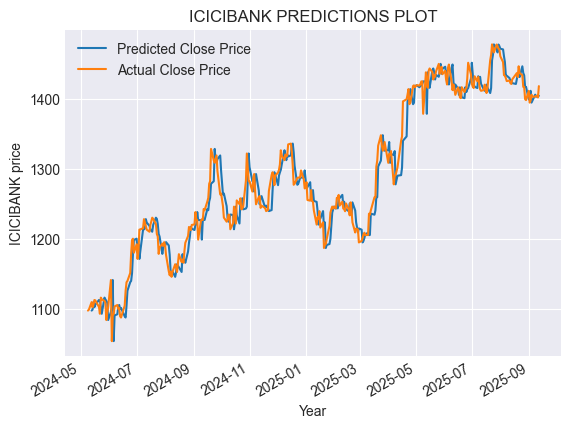

In [78]:

ICICIBANK_test_1d['predicted_price'].shift(1).plot(label='Predicted Close Price')
ICICIBANK_test_1d['Adj Close'].plot(label='Actual Close Price')
plt.xlabel("Year")
plt.ylabel("ICICIBANK price")
plt.title("ICICIBANK PREDICTIONS PLOT")
plt.legend()
plt.show()

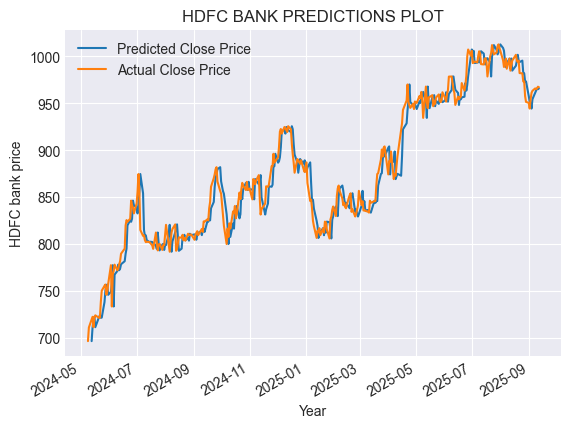

In [38]:
#HDFC_train_1d = HDFC_train_1d.iloc[:i]
HDFC_test_1d['predicted_price'].shift(1).plot(label='Predicted Close Price')
HDFC_test_1d['Adj Close'].plot(label='Actual Close Price')
plt.xlabel("Year")
plt.ylabel("HDFC bank price")
plt.title("HDFC BANK PREDICTIONS PLOT")
plt.legend()
plt.show()

## Step 8 :  Making a Strategy over predicted values for HDFC and Reliance 
## Calculating Stop Loss, transaction costs and risks too just for reference

In [113]:
def backtest_with_costs_and_risk(
        df,
        init_equity=1.0,
        cost_per_side=0.0005,
        slippage_per_side=0.0005,
        risk_per_trade=0.01,
        stop_loss_pct=0.02):
    """
    Simple backtest applying transaction costs, position sizing, and stop-loss.

    df must contain:
      - 'Adj Close' (prices)
      - 'predicted_price' (from your model)
      - optionally 'signal' (1 for long, -1 for short). If absent it is created.

    Parameters:
      init_equity: starting capital
      cost_per_side: commission per trade side (fraction of trade value)
      slippage_per_side: slippage per side (fraction)
      risk_per_trade: fraction of equity risked per trade
      stop_loss_pct: stop-loss distance as fraction

    Returns:
      df_out: copy of df with signals, position_fraction, daily strategy returns, and net equity
    """

    df = df.copy()

    # create simple signal if not provided
    if 'signal' not in df.columns:
        df['signal'] = np.where(df['predicted_price'] > df['Adj Close'], 1, -1)

    # add bookkeeping columns
    extra_cols = ['position_fraction', 'trade_costs',
                  'strategy_returns_raw', 'strategy_returns_net', 'equity']
    for c in extra_cols:
        df[c] = 0.0

    # initialise
    equity = float(init_equity)
    df.loc[df.index[0], 'equity'] = equity
    current_signal = 0
    position_fraction = 0.0
    entry_price = None
    stop_price = None

    for i in tqdm(range(1, len(df)), desc="Backtesting"):
        price = df['Adj Close'].iloc[i]
        prev_price = df['Adj Close'].iloc[i - 1]
        signal = int(df['signal'].iloc[i])
        prev_signal = int(df['signal'].iloc[i - 1])

        trade_costs = 0.0
        strategy_return_raw = 0.0

        # ---- 1) exit logic (stop-loss or signal flip) ----
        if current_signal != 0:
            gross_pct = (price / prev_price - 1.0)
            # stop-loss
            if (current_signal == 1 and price <= stop_price) or \
               (current_signal == -1 and price >= stop_price) or \
               (signal == -current_signal):   # flip
                strategy_return_raw = position_fraction * current_signal * gross_pct
                trade_costs += (cost_per_side + slippage_per_side) * position_fraction * equity
                equity = equity * (1 + strategy_return_raw) - trade_costs
                current_signal = 0
                position_fraction = 0.0
                entry_price = None
                stop_price = None
            else:
                # normal holding
                strategy_return_raw = position_fraction * current_signal * gross_pct
                equity = equity * (1 + strategy_return_raw)

        # ---- 2) entry logic ----
        if current_signal == 0 and signal != prev_signal:
            current_signal = signal
            entry_price = price
            pos_frac = min(1.0, risk_per_trade / stop_loss_pct)
            position_fraction = pos_frac
            stop_price = (entry_price * (1 - stop_loss_pct)
                          if current_signal == 1
                          else entry_price * (1 + stop_loss_pct))
            entry_costs = (cost_per_side + slippage_per_side) * position_fraction * equity
            equity -= entry_costs
            trade_costs += entry_costs

        # record today's metrics
        df.loc[df.index[i], 'position_fraction'] = position_fraction
        df.loc[df.index[i], 'trade_costs'] = trade_costs
        df.loc[df.index[i], 'strategy_returns_raw'] = strategy_return_raw
        df.loc[df.index[i], 'strategy_returns_net'] = (equity / df['equity'].iloc[i - 1]) - 1.0
        df.loc[df.index[i], 'equity'] = equity

    return df

Backtesting: 100%|██████████████████████████████████████████████████████████████████| 336/336 [00:00<00:00, 524.59it/s]


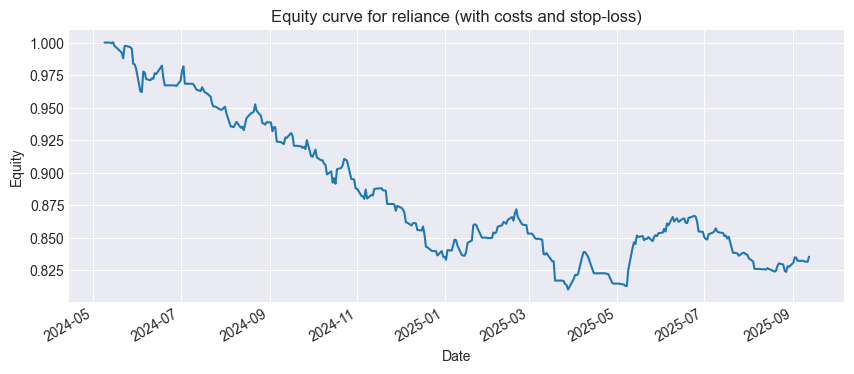

In [114]:
# assuming you have reliance_test_1d with 'Adj Close' and 'predicted_price'
ICICIBANK_result = backtest_with_costs_and_risk(
    ICICIBANK_test_1d,
    **params      # <-- double asterisks unpack key/value pairs
)

# Plot net equity
plt.figure(figsize=(10,4))
ICICIBANK_result['equity'].plot(title="Equity curve for reliance (with costs and stop-loss)")
#(reliance_result['strategy_returns']+1).cumprod().plot()
plt.xlabel("Date")
plt.ylabel("Equity")
plt.show()

### Creating Signals and calculating Strategy returns 

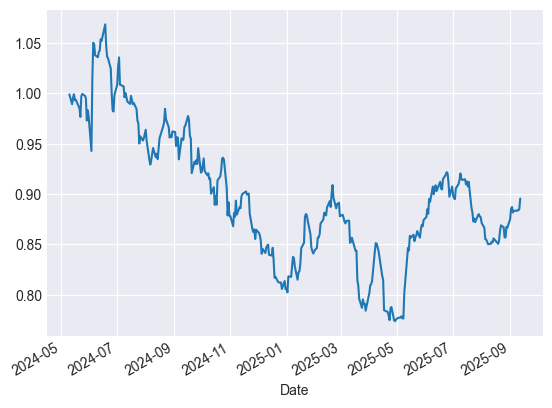

In [111]:
ICICIBANK_test_1d['signal'] = np.where(ICICIBANK_test_1d.predicted_price > ICICIBANK_test_1d['Adj Close'], 1, -1)
ICICIBANK_test_1d['strategy_returns'] = ICICIBANK_test_1d['signal'].shift(1) * ICICIBANK_test_1d['daily_returns']
(ICICIBANK_test_1d['strategy_returns']+1).cumprod().plot()
plt.show()

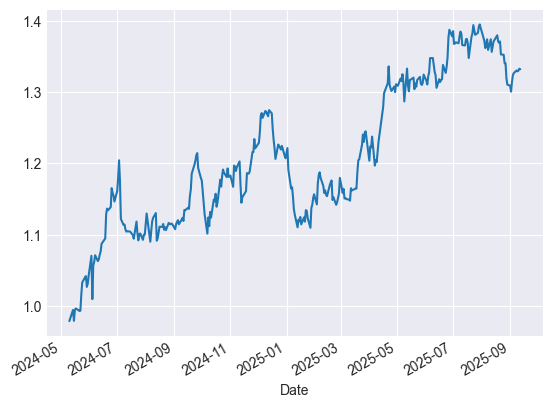

In [63]:
HDFC_test_1d['signal'] = np.where(HDFC_test_1d.predicted_price>HDFC_test_1d['Adj Close'], 1, -1)
HDFC_test_1d['strategy_returns'] = HDFC_test_1d['signal'].shift(1) * HDFC_test_1d['Adj Close'].pct_change()
(HDFC_test_1d['strategy_returns']+1).cumprod().plot()
plt.show()

The Sharpe Ratio is -1.72
The cumulative return is -16.46%
The Buy and Hold return is 28.31%
The maximum drawdown is -19.01%


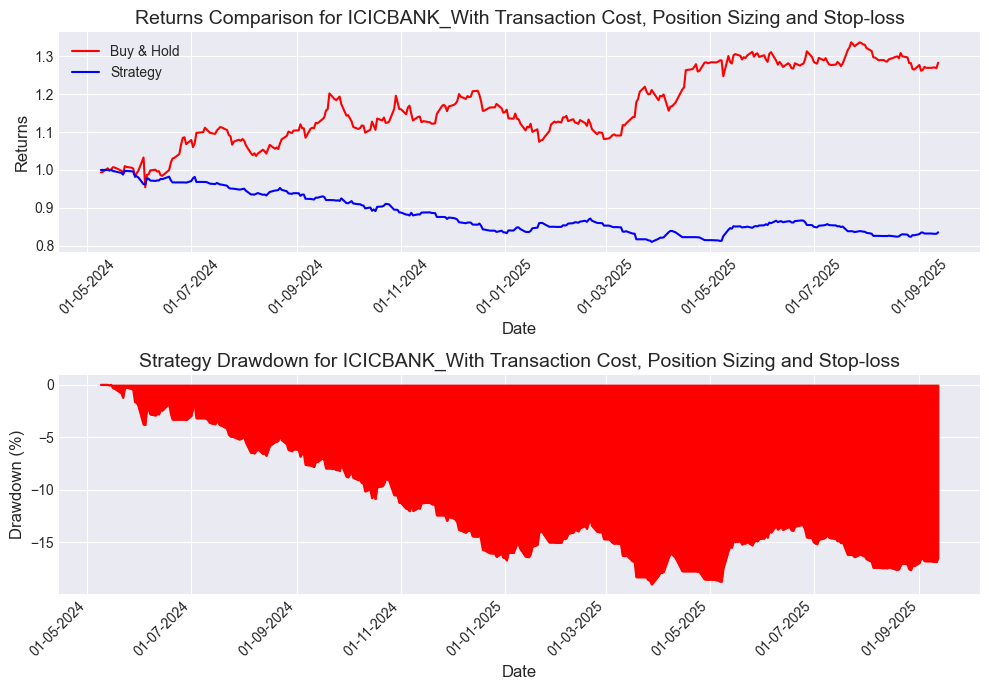

In [120]:
def analyse_strategy(strategy_returns,daily_returns,pathname,stockname):    
    
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

    # Cumulative Returns
    cumulative_returns = (strategy_returns+1).cumprod()

    # Buy and Hold Returns
    BnY_returns = (daily_returns + 1).cumprod()
    
    # ---------- Drawdown calculations -------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = 100*((cumulative_returns)/running_max - 1)

    # Calculate the maximum drawdown
    max_dd = drawdown.min()

    # Print the statistics
    print('The Sharpe Ratio is %.2f' % sharpe_ratio)
    print('The cumulative return is %.2f' % (
      ((cumulative_returns[-1])-1)*100) + "%") 
    print('The Buy and Hold return is %.2f' % (
      ((BnY_returns[-1])-1)*100) + "%")
    print("The maximum drawdown is %.2f" % max_dd + "%")

    # Plot
    labels = strategy_returns.index
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

    # Plot both returns on the same axes
    ax1.plot(BnY_returns.index, BnY_returns, color='r', label='Buy & Hold')
    ax1.plot(cumulative_returns.index, cumulative_returns, color='b', label='Strategy')

    # Titles and labels
    ax1.set_title(f"Returns Comparison for {stockname}" , fontsize=14)
    ax1.set_ylabel('Returns', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)

    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax1.tick_params(axis='x', rotation=45)

    # Add legend
    ax1.legend()
    # Plot max DD
    ax2.plot(drawdown, color='red')
    # Fill in-between the drawdown
    ax2.fill_between(drawdown.index, drawdown.values, color='red')
    ax2.set_title(f'Strategy Drawdown for {stockname}', fontsize=14)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))

    plt.tight_layout()
    plt.savefig(pathname, dpi=300, bbox_inches='tight') 
    plt.show()
    
# Call analyse_strategy
analyse_strategy(ICICIBANK_result['strategy_returns_net'],ICICIBANK_test_1d['daily_returns'],"D://ALGO TRADING EPAT//TIME Series forecasting post for HDFCBANK and ICICIBANK//ICICIBANK_with_cost1.png","ICICBANK_With Transaction Cost, Position Sizing and Stop-loss")  


## This is for ICICI Bank if we include Transaction Costs, Position Sizing and Stop Loss then the maximum drawdown could be reduced but returns also decreases because of costs

### Analyse the Strategy

The Sharpe Ratio is -0.34
The cumulative return is -10.45%
The Buy and Hold return is 28.31%
The maximum drawdown is -27.53%


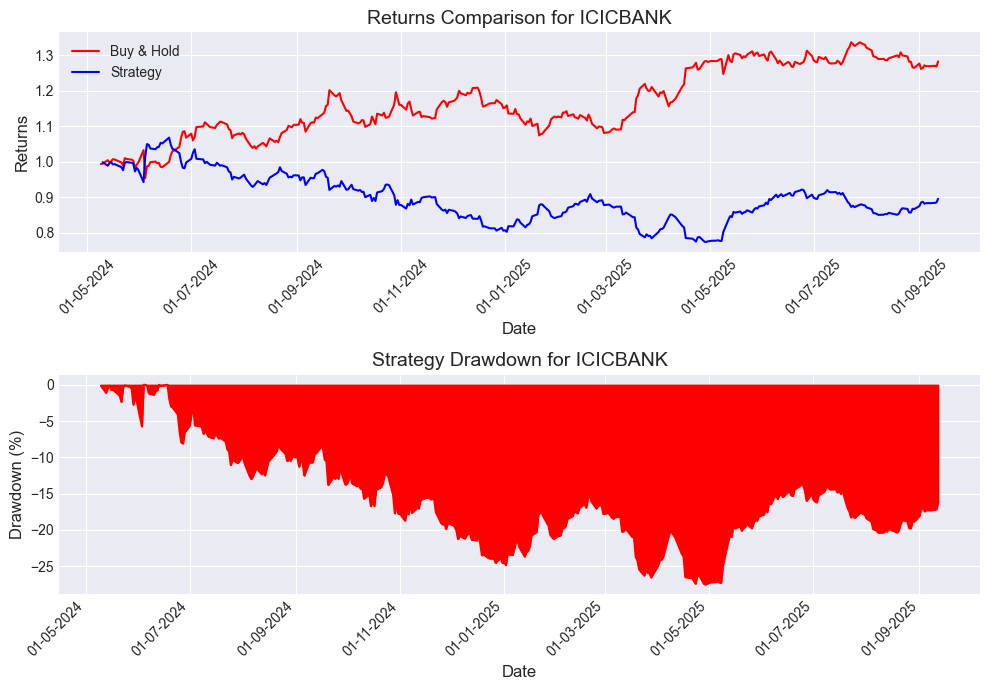

In [121]:
# Call analyse_strategy
analyse_strategy(ICICIBANK_test_1d['strategy_returns'],ICICIBANK_test_1d['daily_returns'],"D://ALGO TRADING EPAT//TIME Series forecasting post for HDFCBANK and ICICIBANK//ICICIBANK.png","ICICBANK")  



The Sharpe Ratio is 1.21
The cumulative return is 33.18%
The Buy and Hold return is 35.57%
The maximum drawdown is -12.93%


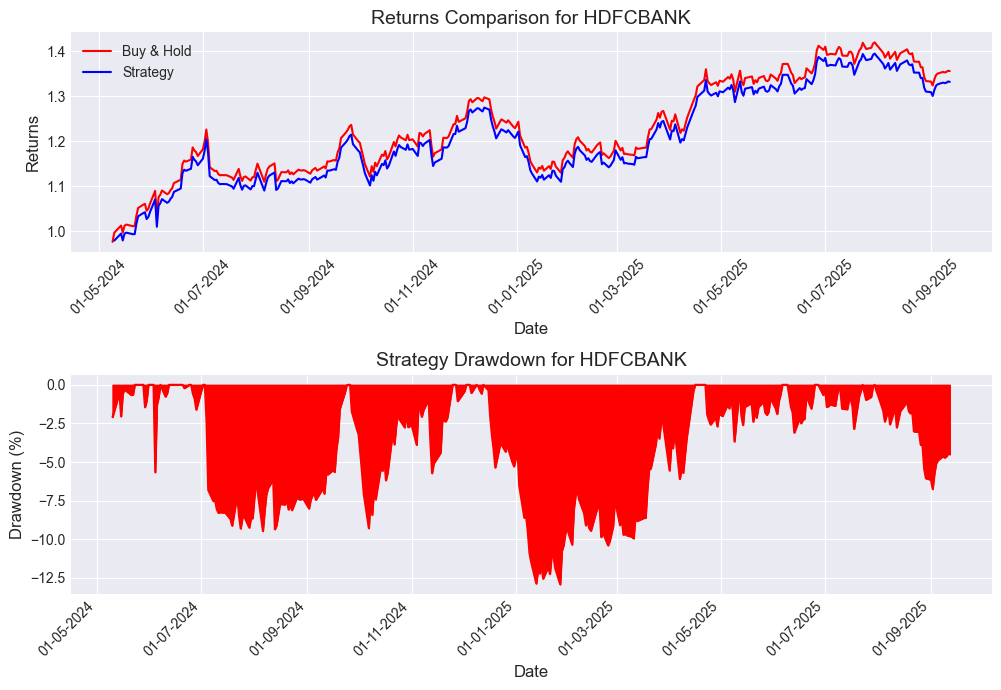

In [122]:
analyse_strategy(HDFC_test_1d['strategy_returns'],HDFC_test_1d['daily_returns'],"D://ALGO TRADING EPAT//TIME Series forecasting post for HDFCBANK and ICICIBANK//HDFCBANK.png","HDFCBANK")

## CALCULATE PERFORMANCE of the STRATEGY

In [87]:
## Calculating performance
def calculate_performance(strategy_returns, actual_returns, strategy_name="Strategy"):
    """
    Calculate strategy performance metrics
    """
    # Remove NaN values
    strat_ret = strategy_returns.dropna()
    actual_ret = actual_returns.dropna()
    
    # Align the series
    common_dates = strat_ret.index.intersection(actual_ret.index)
    strat_ret = strat_ret[common_dates]
    actual_ret = actual_ret[common_dates]
    
    # Calculate metrics
    total_strategy = (1 + strat_ret).cumprod().iloc[-1] - 1
    total_buyhold = (1 + actual_ret).cumprod().iloc[-1] - 1
    
    sharpe_strategy = strat_ret.mean() / strat_ret.std() * np.sqrt(52) if strat_ret.std() > 0 else 0
    sharpe_buyhold = actual_ret.mean() / actual_ret.std() * np.sqrt(52) if actual_ret.std() > 0 else 0
    
    # Win rate
    win_rate = (strat_ret > 0).mean()
    
    # Maximum drawdown
    cumret_strategy = (1 + strat_ret).cumprod()
    drawdown = (cumret_strategy / cumret_strategy.cummax() - 1)
    max_drawdown = drawdown.min()
    
    print(f"{strategy_name} performance report")
    print("=" * 50)
    print(f"Total returns (strategy):  {total_strategy:.2%}")
    print(f"Total returns (buy & hold):  {total_buyhold:.2%}")
    print(f"Excess returns:            {total_strategy - total_buyhold:.2%}")
    print()
    print(f"Sharpe ratio (strategy):  {sharpe_strategy:.2f}")
    print(f"Sharpe ratio (buy & hold):  {sharpe_buyhold:.2f}")
    print()
    print(f"Win rate:                 {win_rate:.1%}")
    print(f"Maximum drawdown:         {max_drawdown:.2%}")
    print()
    
    if total_strategy > total_buyhold:
        print("🎉 Strategy beats buy & hold!")
    else:
        print("😞 Strategy underperforms buy & hold")
        
    return {
        'strategy_return': total_strategy,
        'buyhold_return': total_buyhold,
        'strategy_sharpe': sharpe_strategy,
        'buyhold_sharpe': sharpe_buyhold,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown
    }

# Calculate performance
performance = calculate_performance(
    HDFC_test_1d['strategy_returns'], 
    HDFC_test_1d['daily_returns'],
    "ARIMA Random Forecast Model for HDFCBANK"
)

ARIMA Random Forecast Model for HDFCBANK performance report
Total returns (strategy):  33.18%
Total returns (buy & hold):  38.86%
Excess returns:            -5.68%

Sharpe ratio (strategy):  0.55
Sharpe ratio (buy & hold):  0.62

Win rate:                 54.2%
Maximum drawdown:         -12.93%

😞 Strategy underperforms buy & hold


In [88]:
## Calculating performance
def calculate_performance(strategy_returns, actual_returns, strategy_name="Strategy"):
    """
    Calculate strategy performance metrics
    """
    # Remove NaN values
    strat_ret = strategy_returns.dropna()
    actual_ret = actual_returns.dropna()
    
    # Align the series
    common_dates = strat_ret.index.intersection(actual_ret.index)
    strat_ret = strat_ret[common_dates]
    actual_ret = actual_ret[common_dates]
    
    # Calculate metrics
    total_strategy = (1 + strat_ret).cumprod().iloc[-1] - 1
    total_buyhold = (1 + actual_ret).cumprod().iloc[-1] - 1
    
    sharpe_strategy = strat_ret.mean() / strat_ret.std() * np.sqrt(52) if strat_ret.std() > 0 else 0
    sharpe_buyhold = actual_ret.mean() / actual_ret.std() * np.sqrt(52) if actual_ret.std() > 0 else 0
    
    # Win rate
    win_rate = (strat_ret > 0).mean()
    
    # Maximum drawdown
    cumret_strategy = (1 + strat_ret).cumprod()
    drawdown = (cumret_strategy / cumret_strategy.cummax() - 1)
    max_drawdown = drawdown.min()
    
    print(f"{strategy_name} performance report")
    print("=" * 50)
    print(f"Total returns (strategy):  {total_strategy:.2%}")
    print(f"Total returns (buy & hold):  {total_buyhold:.2%}")
    print(f"Excess returns:            {total_strategy - total_buyhold:.2%}")
    print()
    print(f"Sharpe ratio (strategy):  {sharpe_strategy:.2f}")
    print(f"Sharpe ratio (buy & hold):  {sharpe_buyhold:.2f}")
    print()
    print(f"Win rate:                 {win_rate:.1%}")
    print(f"Maximum drawdown:         {max_drawdown:.2%}")
    print()
    
    if total_strategy > total_buyhold:
        print("🎉 Strategy beats buy & hold!")
    else:
        print("😞 Strategy underperforms buy & hold")
        
    return {
        'strategy_return': total_strategy,
        'buyhold_return': total_buyhold,
        'strategy_sharpe': sharpe_strategy,
        'buyhold_sharpe': sharpe_buyhold,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown
    }

# Calculate performance
performance = calculate_performance(
    ICICIBANK_test_1d['strategy_returns'], 
    ICICIBANK_test_1d['daily_returns'],
    "ARIMA Random Forecast Model for ICICIBANK"
)

ARIMA Random Forecast Model for ICICIBANK performance report
Total returns (strategy):  -10.45%
Total returns (buy & hold):  29.15%
Excess returns:            -39.60%

Sharpe ratio (strategy):  -0.15
Sharpe ratio (buy & hold):  0.50

Win rate:                 48.5%
Maximum drawdown:         -27.53%

😞 Strategy underperforms buy & hold
